<a href="https://colab.research.google.com/github/AbinayaInbamani/plantsvsdiseased/blob/main/Module_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install kaggle tensorflow matplotlib pillow

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abinayainba","key":"9f2f82a0f6443a8a8985861f4a568f97"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("Kaggle setup done")

Kaggle setup done


In [4]:
!kaggle datasets download -d rashikrahmanpritom/plant-disease-recognition-dataset -p .

Dataset URL: https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset
License(s): CC0-1.0
 99% 1.23G/1.25G [00:16<00:00, 107MB/s] 
100% 1.25G/1.25G [00:16<00:00, 82.3MB/s]


In [5]:
!rm -rf plant_demo
!mkdir -p plant_demo
!unzip -o -q plant-disease-recognition-dataset.zip -d plant_demo
print("Unzip done")

Unzip done


In [6]:
import os

train_dir = "plant_demo/Train/Train"
val_dir   = "plant_demo/Validation/Validation"
test_dir  = "plant_demo/Test/Test"

print("Train classes:", os.listdir(train_dir))
print("Validation classes:", os.listdir(val_dir))
print("Test classes:", os.listdir(test_dir))

Train classes: ['Healthy', 'Rust', 'Powdery']
Validation classes: ['Healthy', 'Rust', 'Powdery']
Test classes: ['Healthy', 'Rust', 'Powdery']


In [7]:
import tensorflow as tf

IMG_SIZE = (96,96)
BATCH_SIZE = 4

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes:", class_names)
print("Number of classes:", num_classes)

normalizer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalizer(x), y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (normalizer(x), y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

Found 1322 files belonging to 3 classes.
Found 60 files belonging to 3 classes.
Classes: ['Healthy', 'Powdery', 'Rust']
Number of classes: 3


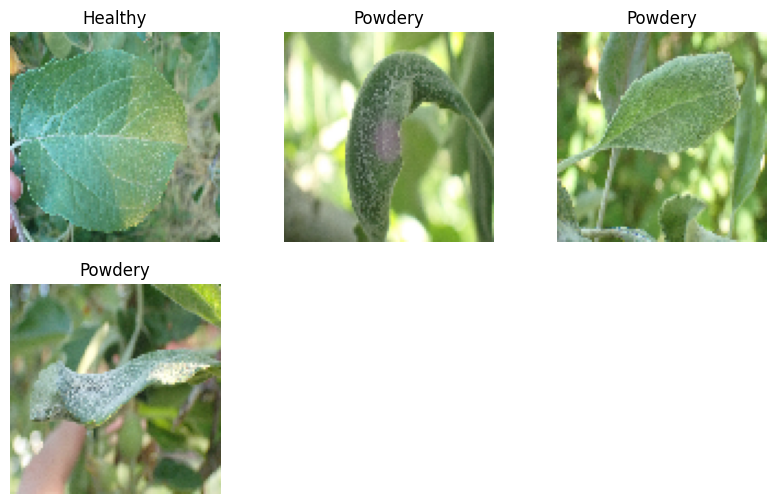

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
    for i in range(min(6, images.shape[0])):
        ax = plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.show()

In [9]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.Conv2D(16, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,443 (1.65 MB)

 Trainable params: 433,443 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    steps_per_epoch=50,
    validation_steps=20
)

Epoch 1/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.2573 - loss: 1.2165

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step - accuracy: 0.2582 - loss: 1.2150 - val_accuracy: 0.4333 - val_loss: 1.0934
Epoch 2/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 0.3480 - loss: 1.0876 - val_accuracy: 0.3833 - val_loss: 1.0438
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 0.4950 - loss: 0.9528 - val_accuracy: 0.5333 - val_loss: 0.8502


In [11]:
import numpy as np

for images, labels in val_ds.take(1):
    probs = model.predict(images, verbose=0)
    pred = int(np.argmax(probs[0]))
    true = int(labels[0])

print("True:", class_names[true])
print("Predicted:", class_names[pred])
print("Confidence:", round(float(np.max(probs[0]))*100, 2), "%")

True: Healthy
Predicted: Powdery
Confidence: 61.8 %


In [12]:
from google.colab import files
uploaded = files.upload()

Saving 8ddaac1bd6c8cd0a.jpg to 8ddaac1bd6c8cd0a.jpg


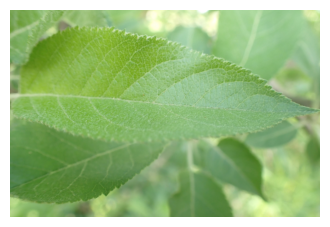

Top predictions:
Healthy - 55.27 %
Rust - 29.91 %
Powdery - 14.82 %


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Uses your existing: model, class_names, IMG_SIZE

def predict_uploaded_image(uploaded_dict):
    img_name = list(uploaded_dict.keys())[0]

    # Show the uploaded image
    img_show = image.load_img(img_name)
    plt.figure(figsize=(4,4))
    plt.imshow(img_show)
    plt.axis("off")
    plt.show()

    # Prepare image for the model
    img = image.load_img(img_name, target_size=IMG_SIZE)
    arr = image.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)

    # Predict
    probs = model.predict(arr, verbose=0)[0]
    top3 = np.argsort(probs)[-3:][::-1]

    print("Top predictions:")
    for i in top3:
        print(class_names[i], "-", round(float(probs[i]) * 100, 2), "%")

predict_uploaded_image(uploaded)